In [500]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from astroquery.mast import Tesscut
from astroquery.mast import Catalogs
import matplotlib.pyplot as plt
import lightkurve
from scipy.signal import find_peaks, peak_prominences
from astropy.convolution import convolve, Box1DKernel
from scipy.optimize import curve_fit
from astropy import modeling

plt.style.use("seaborn-white")


# Cross reference with TESS Sectors

In [3]:
# Collect list of stellar parameter files
stellar_param_files = glob.glob("pydata/sumout_files/*")

In [4]:
# Generate Stellar Parameter DataFrame
stellar_param_dict = {}
files = ["pydata/sumout_files/11Com_2012.m.sumout"]
for file in stellar_param_files:
    with open(file,'r') as f:
        for i, line in enumerate(f):
            if i == 0:
                star = f.readline().split(" ")[0].split("_")[0] # fix this for ngc
                #print(star)
                params = [elem for elem in f.readline().split(" ") if elem != '']
                #print(params)
                metallicity = params[-2]
                if '-' in metallicity:
                    metallicity = metallicity[4:]
                file_dict = {'Teff': float(params[2]), 'Log_g':float(params[6]), 'M/H':float(metallicity)}
                #print(file_dict)
                stellar_param_dict[star] = file_dict
                
param_df = pd.DataFrame.from_dict(stellar_param_dict, orient='index')

In [5]:
stars = list(param_df.index)
print(stars)

param_df.loc[stars[0]]

['11Com', '18Del', '24Sex', '7CMa', '81Cet', 'AlphaAri', 'BD+12', 'BD+20274', 'GammaLeoA', 'HD100655', 'HD102272', 'HD102329', 'HD105096', 'HD108863', 'HD108991', 'HD115202', 'HD116029', 'HD118082', 'HD11977', 'HD121056', 'HD121156', 'HD123239', 'HD125217', 'HD126105', 'HD131496', 'HD1502', 'HD1690', 'HD17311', 'HD175541', 'HD176884', 'HD180902', 'HD181342', 'HD18742', 'HD188105', 'HD19138', 'HD192699', 'HD194937', 'HD19810', 'HD198599', 'HD200964', 'HD203638', 'HD205478', 'HD206610', 'HD20924', 'HD210702', 'HD212771', 'HD213066', 'HD21340', 'HD219553', 'HD233860', 'HD24148', 'HD24316', 'HD25069', 'HD28678', 'HD30128', 'HD30856', 'HD31693', 'HD31860', 'HD33142', 'HD33240', 'HD34909', 'HD39079', 'HD4313', 'HD45433', 'HD5319', 'HD58540', 'HD5877', 'HD5891', 'HD6037', 'HD64152', 'HD6665', 'HD68776', 'HD72292', 'HD73534', 'HD76321', 'HD84561', 'HD94386', 'HD95089', 'HD96036', 'HD96683', 'HD98219', 'HD98516', 'HD98579', 'HIP113622', 'HIP117756', 'Tyc0017-01084-1', 'Tyc0683-01190-1', 'Tyc120

Teff     4810.00
Log_g       2.51
M/H        -0.28
Name: 11Com, dtype: float64

### TESS Queries

In [6]:
# Example Query

target_name = "HD209458"
search_radius_deg = 0.05

catalogTIC = Catalogs.query_object(target_name, radius=search_radius_deg, catalog="TIC")
where_closest = np.argmin(catalogTIC['dstArcSec'])
print("Closest TIC ID to %s: TIC %s, separation of %f arcsec. and a TESS mag. of %f"%
      (target_name, catalogTIC['ID'][where_closest], catalogTIC['dstArcSec'][where_closest],
      catalogTIC['Tmag'][where_closest]))

print(catalogTIC.colnames)
#print(catalogTIC['Teff'][where_closest])

Closest TIC ID to HD209458: TIC 420814525, separation of 0.000012 arcsec. and a TESS mag. of 7.127400
['ID', 'ra', 'dec', 'pmRA', 'pmDEC', 'Tmag', 'objType', 'typeSrc', 'version', 'HIP', 'TYC', 'UCAC', 'TWOMASS', 'SDSS', 'ALLWISE', 'GAIA', 'APASS', 'KIC', 'POSflag', 'e_pmRA', 'e_pmDEC', 'PMflag', 'plx', 'e_plx', 'PARflag', 'gallong', 'gallat', 'eclong', 'eclat', 'Bmag', 'e_Bmag', 'Vmag', 'e_Vmag', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag', 'TWOMflag', 'prox', 'w1mag', 'e_w1mag', 'w2mag', 'e_w2mag', 'w3mag', 'e_w3mag', 'w4mag', 'e_w4mag', 'GAIAmag', 'e_GAIAmag', 'e_Tmag', 'TESSflag', 'SPFlag', 'Teff', 'e_Teff', 'logg', 'e_logg', 'MH', 'e_MH', 'rad', 'e_rad', 'mass', 'e_mass', 'rho', 'e_rho', 'lumclass', 'lum', 'e_lum', 'd', 'e_d', 'ebv', 'e_ebv', 'numcont', 'contratio', 'disposition', 'duplicate_id', 'priority', 'eneg_EBV', 'epos_EBV', 'EBVflag', 'eneg_Mass', 'epos_Mass', 'eneg_Rad', 'ep

In [7]:
# Generate Comparison Dictionary

comp_dict = {}

search_radius_deg=0.05
for star in stars:
    target_name = star
    if target_name == "AlphaAri":
        target_name = "HD12929"
    elif target_name == "GammaLeoA":
        target_name = "HD89484"
    elif target_name == "xiAql":
        target_name = "HD188310"
        
    try:
        catalogTIC = Catalogs.query_object(target_name, radius=search_radius_deg, catalog="TIC")
        where_closest = np.argmin(catalogTIC['dstArcSec'])
        if catalogTIC['dstArcSec'][where_closest] >= 0.4: # Ignore anything off by more than 0.4 arcseconds
            continue
        
        # Get the TESS sectors in which the object has been observed (if any)
        cameras = []
        sectors = []
        ccds = []
        sector_Table = Tesscut.get_sectors(star) # Get the TESS sectors in which the object has been observed (if any)
        if len(sector_Table) != 0:
            for i in range(len(sector_Table)):
                cameras.append(sector_Table[i][2])
                sectors.append(sector_Table[i][1])
                ccds.append(sector_Table[i][3])
        
        star_dict = {"TIC":catalogTIC['ID'][where_closest],
                     "TESS_cameras":cameras,
                     "TESS_sectors":sectors,
                     "TESS_ccds":ccds,
                     "meas_Teff": param_df.loc[star]["Teff"],
                     "meas_logg": param_df.loc[star]["Log_g"],
                     "meas_MH": param_df.loc[star]["M/H"],
                     "TESS_Teff": catalogTIC['Teff'][where_closest], 
                     "TESS_e_Teff": catalogTIC['e_Teff'][where_closest],
                     "TESS_logg": catalogTIC['logg'][where_closest],
                     "TESS_e_logg": catalogTIC['e_logg'][where_closest],
                     "TESS_MH": catalogTIC['MH'][where_closest],
                     "TESS_e_MH": catalogTIC['e_MH'][where_closest]}
        
        comp_dict[star] = star_dict
        
            
    except:
        print("No match found for {}".format(target_name))

comp_df = pd.DataFrame.from_dict(comp_dict, orient='index')
comp_df = comp_df[['TIC',"TESS_sectors", "TESS_cameras", "TESS_ccds", "meas_Teff", "TESS_Teff", 
                   'TESS_e_Teff',"meas_logg","TESS_logg","TESS_e_logg","meas_MH","TESS_MH", "TESS_e_MH"]]

No match found for HD12929
No match found for BD+12
No match found for HD89484
No match found for epsRet
No match found for epsTau
No match found for epsilonRet
No match found for HD188310


In [9]:
# Get the subsets of comp_df that has TESS measurements and errors for the various stellar parameters

mask = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_e_Teff'])]
teff_df = comp_df[mask]

mask = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_e_logg'])]
logg_df = comp_df[mask]

# M/H has an entry with an uncertainty but no measurement so we need to double up on masks here
mask_e = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_e_MH'])]
mask_val = [type(element) != np.ma.core.MaskedConstant for element in np.array(comp_df['TESS_MH'])]
mask = np.array(mask_e) * np.array(mask_val)
MH_df = comp_df[mask]

print("Teff matches: {}".format(len(teff_df)),
      "logg matches: {}".format(len(logg_df)), 
      "M/H matches: {}".format(len(MH_df)))

print("Median Temperature Difference: {}".format(np.median(abs(teff_df['meas_Teff'] - teff_df['TESS_Teff']))))
print("Median Logg Difference: {}".format(np.median(abs(logg_df['meas_logg'] - logg_df['TESS_logg']))))
print("Median M/H Difference: {}".format(np.median(abs(MH_df['meas_MH'] - MH_df['TESS_MH']))))


Teff matches: 84 logg matches: 4 M/H matches: 54
Median Temperature Difference: 51.0
Median Logg Difference: 1.1781700000000002
Median M/H Difference: 0.0734752


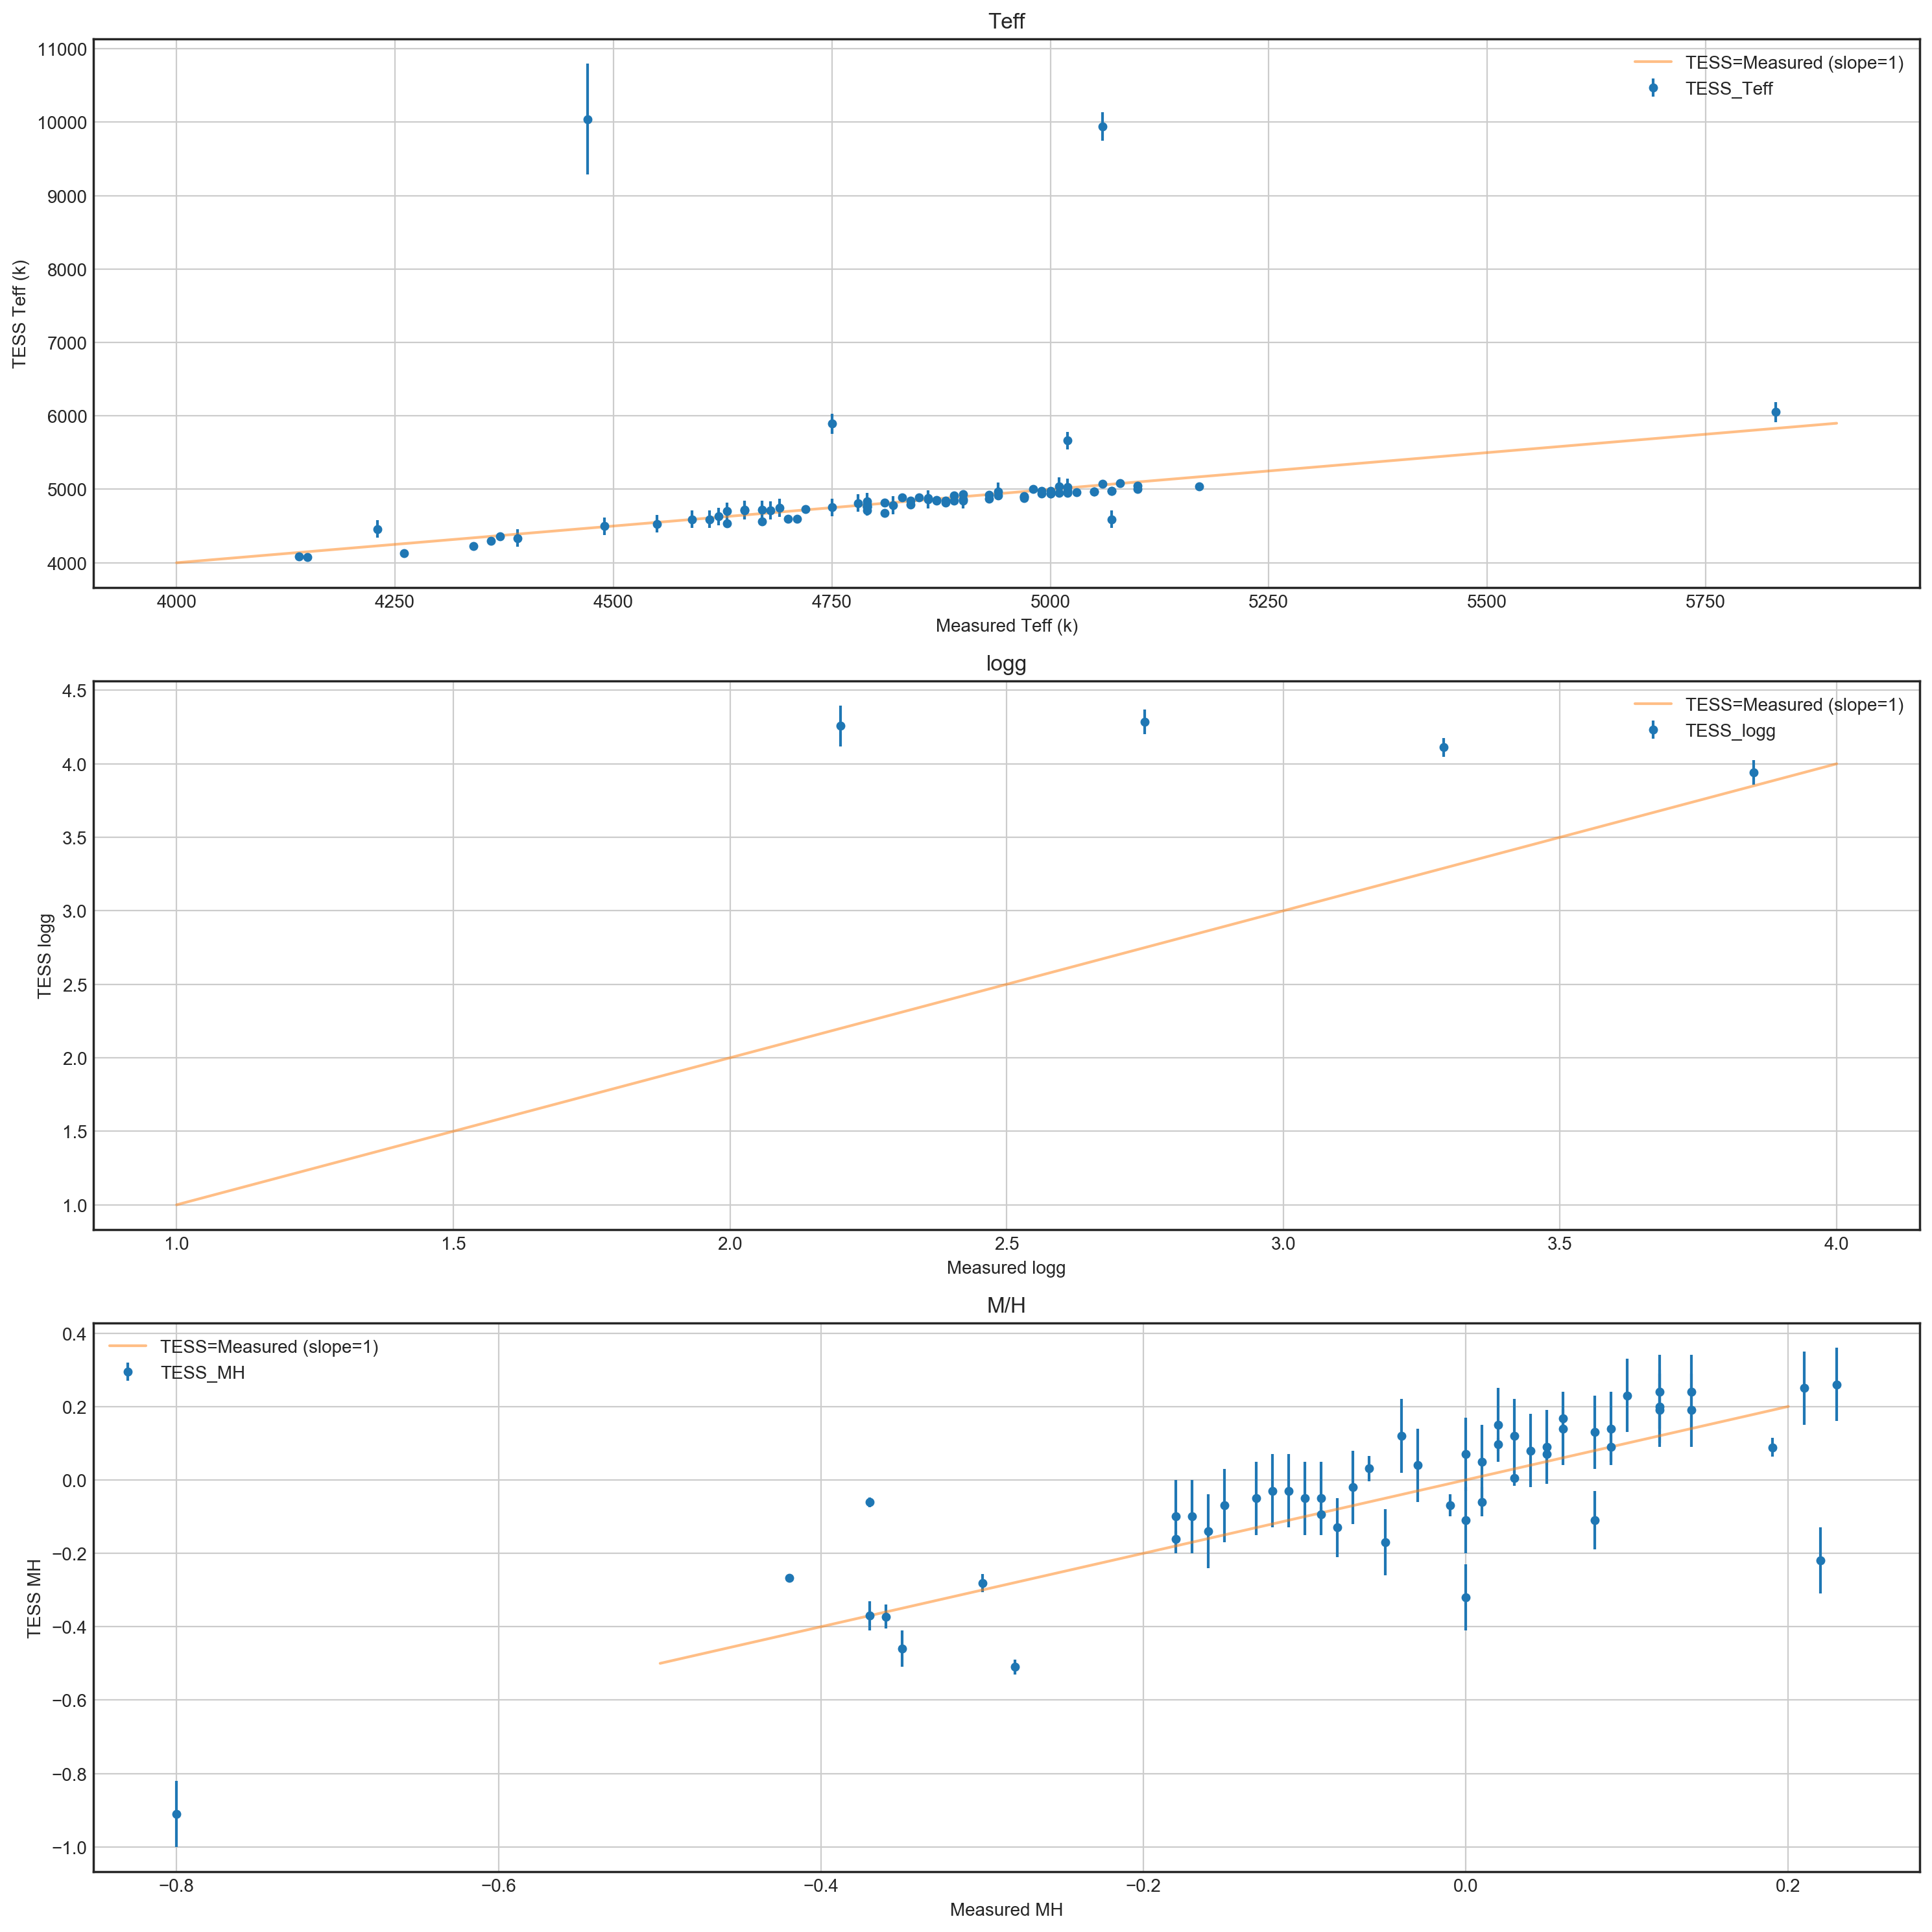

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15), dpi = 200)


ax1.errorbar(teff_df['meas_Teff'], teff_df['TESS_Teff'],teff_df['TESS_e_Teff'],fmt='.', markersize=8)
ax1.set_title("Teff")
ax1.set_ylabel("TESS Teff (k)")
ax1.set_xlabel("Measured Teff (k)")
#ax1.set_ylim(3500,6500)
x = np.arange(4000, 6000, 100)
y = x
ax1.plot(x,y, alpha=0.5, label="TESS=Measured (slope=1)")
ax1.grid()
ax1.legend()

ax2.errorbar(logg_df['meas_logg'], logg_df['TESS_logg'],logg_df['TESS_e_logg'],fmt='.', markersize=8)
ax2.set_title("logg")
ax2.set_ylabel("TESS logg")
ax2.set_xlabel("Measured logg")
x = np.arange(1., 4.1, 1.)
y = x
ax2.plot(x,y, alpha=0.5, label="TESS=Measured (slope=1)")
ax2.grid()
ax2.legend()

ax3.errorbar(MH_df['meas_MH'], MH_df['TESS_MH'],MH_df['TESS_e_MH'],fmt='.', markersize=8)
ax3.set_title("M/H")
ax3.set_ylabel("TESS MH")
ax3.set_xlabel("Measured MH")
x = np.arange(-0.5, 0.3, 0.1)
y = x
ax3.plot(x,y, alpha=0.5, label="TESS=Measured (slope=1)")
ax3.grid()
ax3.legend()

plt.tight_layout()

#HD 39079 and HD 96036 are A type stars? Way too hot, maybe biting on the wrong stars here from the IDs?

## Astroseismic Surface Gravities from TESS Sector Light Curves

In [11]:
mask = [len(sectors) != 0 for sectors in np.array(comp_df['TESS_sectors'])]
tess_df = comp_df[mask]
tess_df

,TIC,TESS_sectors,TESS_cameras,TESS_ccds,meas_Teff,TESS_Teff,TESS_e_Teff,meas_logg,TESS_logg,TESS_e_logg,meas_MH,TESS_MH,TESS_e_MH
24Sex,1713457,[8],[1],[3],5020.0,5027,122,3.40,--,--,0.00,--,--
7CMa,48237215,[6],[2],[2],4790.0,4794.52,24.1018,3.21,--,--,0.19,0.0882353,0.0257248
81Cet,35725282,[4],[1],[4],4900.0,4844.29,6.49938,2.89,--,--,0.03,0.00440225,0.0203455
HD105096,66933951,"[10, 11]","[2, 2]","[2, 1]",4750.0,4753,122,3.11,--,--,0.08,--,--
HD108991,130867823,[10],[1],[2],4790.0,4762,122,3.03,--,--,-0.02,--,--
HD115202,422432907,[10],[1],[3],4830.0,4889,30,3.20,--,--,0.01,-0.06,0.04
HD11977,232074535,"[1, 2]","[3, 3]","[4, 3]",4980.0,5004.87,14.116,2.76,--,--,-0.18,-0.161001,0.0203536
HD121056,111947706,[11],[1],[1],4790.0,4711,50,3.21,--,--,-0.00,-0.11,0.09
HD121156,72593986,[11],[1],[4],4670.0,4722,123,3.07,--,--,0.26,--,--
HD1690,37763102,[3],[1],[4],4370.0,4360.7,16.96,1.91,--,--,-0.30,-0.2812,0.024


In [12]:
# Get light curves from known TICs (not all sectors have been observed currently)

for TIC in tess_df['TIC']:
    search_results = lightkurve.search.search_lightcurvefile(TIC, cadence="short", mission='TESS')
    print(search_results)
    if len(search_results) > 0:
        search_results.download_all(download_dir = "/Users/dbranton/redgiant_planethosts/astroseismic/data/")
     

SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
    1713457 tess2019032160000-s0008-0000000001713457-0136-s_lc.fits Light curves      0.0
SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
   48237215 tess2018349182459-s0006-0000000048237215-0126-s_lc.fits Light curves      0.0


No data found for target "35725282".


SearchResult containing 0 data products.
SearchResult containing 0 data products.
SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  130867823 tess2019085135100-s0010-0000000130867823-0140-s_lc.fits Light curves      0.0
SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  422432907 tess2019085135100-s0010-0000000422432907-0140-s_lc.fits Light curves      0.0


No data found for target "232074535".


SearchResult containing 0 data products.
SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  111947706 tess2019112060037-s0011-0000000111947706-0143-s_lc.fits Light curves      0.0
SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
   72593986 tess2019112060037-s0011-0000000072593986-0143-s_lc.fits Light curves      0.0
SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
   37763102 tess2018263035959-s0003-0000000037763102-0123-s_lc.fits Light curves      0.0
SearchResult containing

No data found for target "406500991".


SearchResult containing 0 data products.
SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
     612908 tess2018319095959-s0005-0000000000612908-0125-s_lc.fits Light curves      0.0


No data found for target "244256625".


SearchResult containing 0 data products.
SearchResult containing 0 data products.
SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  169397663 tess2018319095959-s0005-0000000169397663-0125-s_lc.fits Light curves      0.0
SearchResult containing 0 data products.
SearchResult containing 0 data products.
SearchResult containing 0 data products.
SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
   42819747 tess2018349182459-s0006-0000000042819747-0126-s_lc.fits Light curves      0.0
SearchResult containing 5 data products.

target_name                     productFilename                     description  distance
----------- ---------------------------

In [13]:
# Glob in the TESS lightcurves

lcfs = glob.glob("/Users/dbranton/redgiant_planethosts/astroseismic/data/mastDownload/TESS/*/*")

nu_max = 274.5
T_eff = 3796.11
nu_max_sol = 3140.
T_sol = 5777.
g_sun = const.G.cgs*const.M_sun.cgs/(const.R_sun.cgs)**2

def logg_to_nu_max(logg,temp):
    g_obs = 10**logg
    nu_max_exp2 = nu_max_sol*g_obs/g_sun.value * np.sqrt(T_sol/temp)
    return nu_max_exp2

def nu_max_to_logg(nu_max,temp):
    g_obs = g_sun.value*(nu_max/nu_max_sol)*np.sqrt(temp/T_sol)
    return np.log10(g_obs)

print(logg_to_nu_max(2.91, 5067)) #Exoplanets.org value
print(logg_to_nu_max(2.76, 4980)) # Our values


print(nu_max_to_logg(56.0, 5067)) # exoplanet's.org temp
print(nu_max_to_logg(56.0, 4980))# using our temp

99.38886987852419
70.97387759322397
2.660850274610748
2.6570894938452714


/Users/dbranton/miniconda3/envs/astro36/lib/python3.6/site-packages/pandas/core/series.py:91: UserWarning: Warning: converting a masked element to nan.
  return converter(self.iloc[0])


234.81193277793705
232.63369441045248


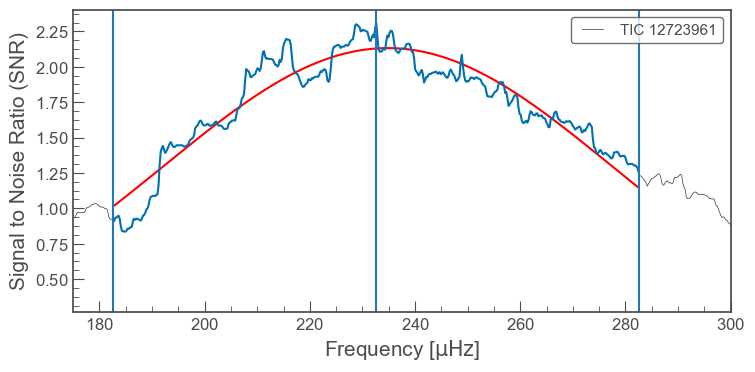

In [584]:
#Do Nu_maxes by hand
idx = 1
for lcf in lcfs[idx:idx+1]:
    match_df = tess_df.loc[tess_df['TIC'] == str(int(lcf.split("/")[-1].split("-")[2]))]
    nu_max_lc = logg_to_nu_max(float(match_df["meas_logg"]), float(match_df["meas_Teff"])) #measured value
    nu_max_lc_tess = logg_to_nu_max(float(match_df["TESS_logg"]), float(match_df["TESS_Teff"])) #measured value
    lc = lightkurve.open(lcf).PDCSAP_FLUX
    per3=lc.remove_nans().fill_gaps().to_periodogram(minimum_period=5*u.minute,oversample_factor=10,normalization='psd').bin(binsize=5)
    per3= per3.flatten(filter_width=0.2).smooth(filter_width=25)
    
    #Gaussian fit with max power frequency as guess for center

    def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
    window=50
    nu_max_guess = per3.frequency_at_max_power.value
    mask = (np.array(per3.frequency) < nu_max_guess + window) * (np.array(per3.frequency) > nu_max_guess - window)
    masked_power = np.array(per3.power[mask])
    masked_frequency = np.array(per3.frequency.value[mask])
    
    n = len(masked_frequency)                          #the number of data
    mean = sum(masked_frequency*masked_power)/n                   #note this correction
    sigma = sum(masked_power*(masked_frequency-mean)**2)/n  
    popt,pcov = curve_fit(gaus,masked_frequency,masked_power,p0=[1,nu_max_guess,25])
    nu_max=popt[1]
    print(nu_max)
    
    
    
    per3.plot(unit=u.microHertz,scale='linear')
    plt.plot(masked_frequency,gaus(masked_frequency,*popt),label='fit', color='r')
    plt.plot(masked_frequency,masked_power,label='fit')
    plt.xlim(175,300)
    #plt.ylim(1,1e5)
    print(per3.frequency_at_max_power.value)
    plt.axvline(per3.frequency_at_max_power.value)
    plt.axvline(per3.frequency_at_max_power.value-window)
    plt.axvline(per3.frequency_at_max_power.value+window)
    plt.axvline(nu_max_lc, color='g')
    plt.axvline(nu_max_lc_tess, color='r')
    #plt.axvline(63)
    

In [550]:
#Do Nu_maxes by flattening
flatten_nu_maxes = {}
gauss_fitted_nu_maxes = {}
for lcf in lcfs:
    match_df = tess_df.loc[tess_df['TIC'] == str(int(lcf.split("/")[-1].split("-")[2]))]
    #nu_max_lc = logg_to_nu_max(float(match_df["meas_logg"]), float(match_df["meas_Teff"])) #measured value
    #nu_max_lc_tess = logg_to_nu_max(float(match_df["TESS_logg"]), float(match_df["TESS_Teff"])) #measured value
    lc = lightkurve.open(lcf).PDCSAP_FLUX
    per3=lc.remove_nans().fill_gaps().to_periodogram(minimum_period=5*u.minute,oversample_factor=10,normalization='psd').bin(binsize=5)
    per3= per3.flatten(filter_width=0.2).smooth(filter_width=25)
    if per3.frequency_at_max_power.value < 1000.:
        flatten_nu_maxes[str(int(lcf.split("/")[-1].split("-")[2]))] = per3.frequency_at_max_power.value
        
    else:
        flatten_nu_maxes[str(int(lcf.split("/")[-1].split("-")[2]))] = np.nan
        gauss_fitted_nu_maxes[str(int(lcf.split("/")[-1].split("-")[2]))] = np.nan
        continue
    #Gaussian fit with max power frequency as guess for center

    def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
    
    nu_max_guess = per3.frequency_at_max_power.value
    mask = (np.array(per3.frequency) < nu_max_guess + 50) * (np.array(per3.frequency) > nu_max_guess - 50)
    masked_power = np.array(per3.power[mask])
    masked_frequency = np.array(per3.frequency.value[mask])
    
    n = len(masked_frequency)                          #the number of data
    mean = sum(masked_frequency*masked_power)/n                   #note this correction
    sigma = sum(masked_power*(masked_frequency-mean)**2)/n  
    popt,pcov = curve_fit(gaus,masked_frequency,masked_power,p0=[1,nu_max_guess,25])
    nu_max=popt[1]
    gauss_fitted_nu_maxes[str(int(lcf.split("/")[-1].split("-")[2]))] = nu_max


109.51167927126865 uHz
2.9266415724614654 3.08
152.31483530539998


(0.1, 100000.0)

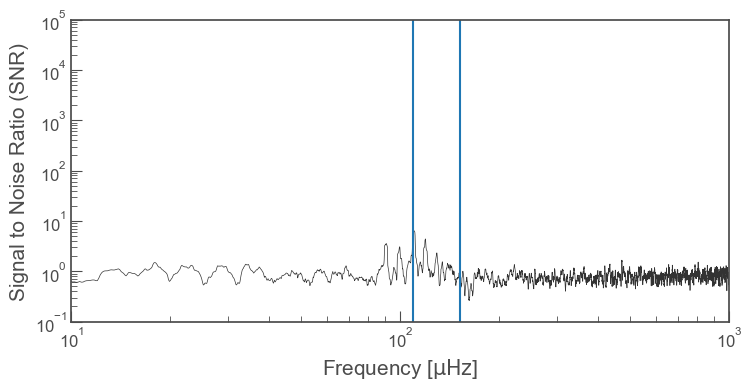

In [567]:
#Generate the Matched Pandas Dataframe that just contains the TESS Id for 339728935
match_df = tess_df.loc[tess_df['TIC'] == '339728935']

#Create a TessLightCurve Object Instance
lc_stacked = lightkurve.TessLightCurve(flux=np.array([]), time=np.array([]),flux_err=np.array([]),
                                       quality=np.array([]), cadenceno=np.array([]), 
                                       centroid_col=np.array([]), centroid_row=np.array([]))

#Stack the flux, time, and other property arrays into the stacked TessLightCurve object
stack_lcfs = [lcf for lcf in lcfs if '339728935' in lcf]
for lcf in stack_lcfs[:]:
    lc = lightkurve.open(lcf).PDCSAP_FLUX
    lc_stacked.flux = np.concatenate((lc_stacked.flux,lc.flux/np.median(lc.remove_nans().flux)))
    lc_stacked.time = np.concatenate((lc_stacked.time,lc.time))
    lc_stacked.flux_err = np.concatenate((lc_stacked.flux_err,lc.flux_err))
    lc_stacked.quality = np.concatenate((lc_stacked.quality,lc.quality))
    lc_stacked.cadenceno = np.concatenate((lc_stacked.cadenceno,lc.cadenceno))
    lc_stacked.centroid_col = np.concatenate((lc_stacked.centroid_col,lc.centroid_col))
    lc_stacked.centroid_row = np.concatenate((lc_stacked.centroid_row,lc.centroid_row))
    
    #per3=lc.remove_nans().fill_gaps().to_periodogram(minimum_period=5*u.minute,oversample_factor=10,normalization='amplitude').bin(binsize=20)
    #per3.plot(unit=u.microHertz,scale='log')

# Convert the stacked_lc to a periodogram
per3=lc_stacked.remove_nans().fill_gaps().to_periodogram(minimum_period=5*u.minute,oversample_factor=10,normalization='psd').bin(binsize=20)
#per3= per3.smooth(filter_width=5)
per3= per3.flatten(filter_width=0.2).smooth(filter_width=2)
print(per3.frequency_at_max_power)
per3.plot(unit=u.microHertz,scale='log')


nu_max_lc = logg_to_nu_max(float(match_df["meas_logg"]), float(match_df["meas_Teff"])) #measured value
logg_out = nu_max_to_logg(nu_max=107., temp=float(match_df['meas_Teff']))
print(logg_out,float(match_df['meas_logg']))


print(nu_max_lc)
#print(per3.frequency_at_max_power)
plt.axvline(nu_max_lc)
plt.axvline(per3.frequency_at_max_power.value)
plt.xlim(10,1000)
plt.ylim(1e-1,1e5)

In [315]:
# Save stacked lc for Joleen and write a little tutorial for loading it
import pickle
save_file = open("stacked_lc.obj", 'wb')
pickle.dump(lc_stacked, save_file)


In [310]:
#Test out loading it

import pickle
obj_file = open('stacked_lc.obj', 'rb')
loaded_lc = pickle.load(obj_file)

In [294]:
#nu_maxes = {'9710105':285.0, '12723961':230.0, '10784960':55.0, '37763102':np.nan, '339728935':107.0,
#           '71345433':125.0, '423762307':110.0, '612908':172.0, '49952922': 190.0, '169397663':275.0,
#           '449145115':119.0, '42837215':np.nan, '48237215':193.0, '27654333':50.0,'141933991':83.0,
#           '1713457':175.0,'375563752':63.0}

nu_max_data = {'TIC':['9710105', '12723961', '10784960', '37763102', '339728935','71345433', '423762307', 
                      '612908', '49952922', '169397663','449145115', '42837215', '48237215', '27654333',
                      '141933991','1713457','375563752'], 
               'astroseismic nu_max':[285.0, 230.0, 55.0, np.nan, 107.0, 125.0, 110.0, 172.0, 190.0, 275.0, 119.0, 
                         np.nan, 193.0, 50.0,83.0, 175.0,63.0]}

nu_max_df = pd.DataFrame.from_dict(nu_max_data)
cross_matched_df = pd.merge(tess_df, nu_max_df, on=['TIC'], how='inner')
cross_matched_df['nu_max from logg'] = [logg_to_nu_max(params[0], params[1]) for _, params in cross_matched_df[['meas_logg', 'meas_Teff']].iterrows()]

In [295]:
cross_matched_df

,TIC,TESS_sectors,TESS_cameras,TESS_ccds,meas_Teff,TESS_Teff,TESS_e_Teff,meas_logg,TESS_logg,TESS_e_logg,meas_MH,TESS_MH,TESS_e_MH,astroseismic nu_max,nu_max from logg
0,1713457,[8],[1],[3],5020.0,5027,122,3.40,--,--,0.00,--,--,175.0,308.575432
1,48237215,[6],[2],[2],4790.0,4794.52,24.1018,3.21,--,--,0.19,0.0882353,0.0257248,193.0,203.960209
2,37763102,[3],[1],[4],4370.0,4360.7,16.96,1.91,--,--,-0.30,-0.2812,0.024,NaN,10.702186
3,71345433,[4],[2],[4],4990.0,4940,25,3.17,--,--,-0.13,-0.05,0.1,125.0,182.248067
4,12723961,[2],[1],[4],5100.0,5003,25,3.52,--,--,-0.09,-0.05,0.1,230.0,403.578588
5,423762307,[4],[2],[2],4970.0,4908,25,3.16,--,--,-0.12,--,0.1,110.0,178.457584
6,49952922,[5],[1],[1],4900.0,4933.35,36.4368,3.33,--,--,0.06,0.167059,0.0257248,190.0,265.836839
7,449145115,[5],[1],[3],5050.0,4972,25,3.15,--,--,-0.17,-0.1,0.1,119.0,173.008530
8,612908,[5],[2],[2],4970.0,4895,25,3.31,--,--,-0.11,-0.03,0.1,172.0,252.078038
9,169397663,[5],[2],[3],5000.0,4978,25,3.50,--,--,0.05,0.09,0.1,275.0,389.249625


57.24806743030936


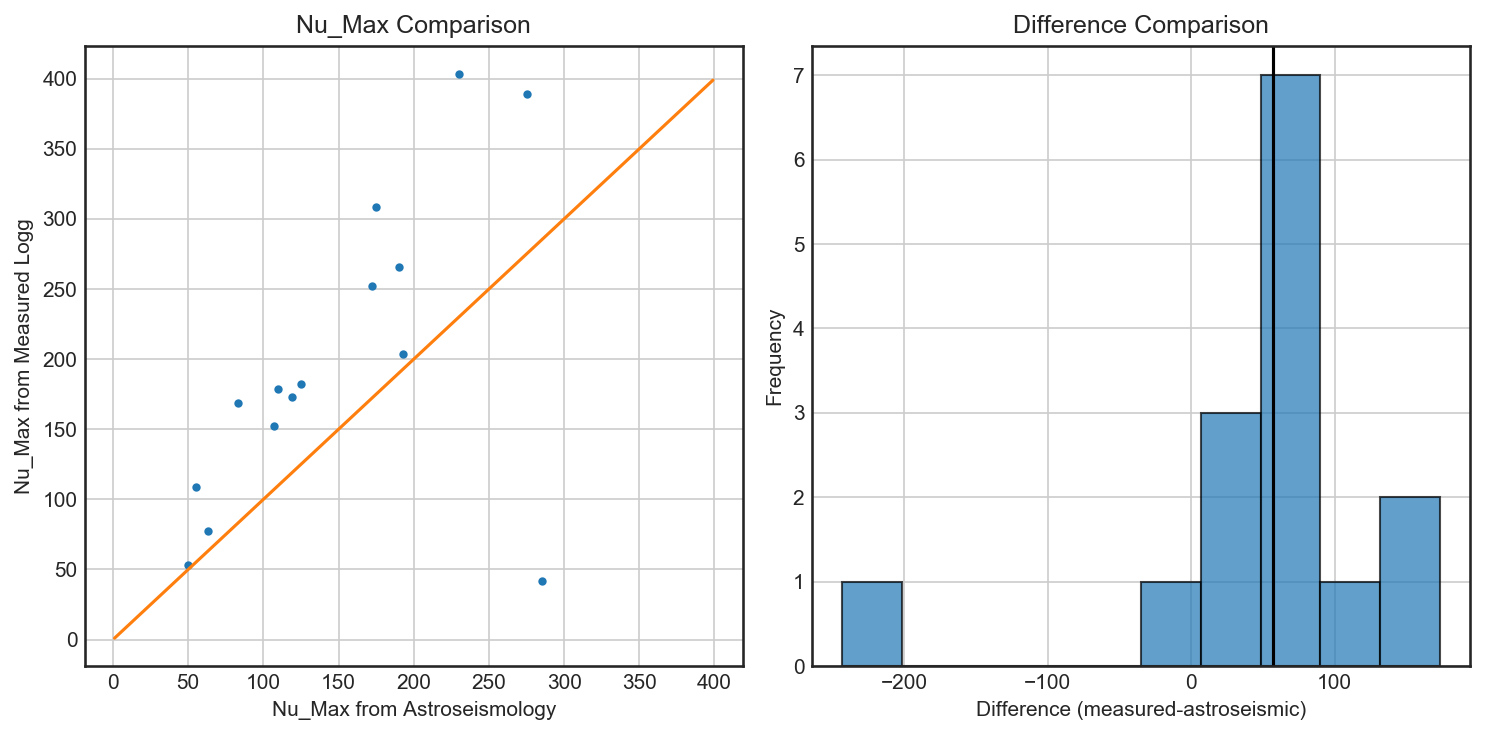

In [346]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=150)

ax1.plot(cross_matched_df['astroseismic nu_max'], cross_matched_df['nu_max from logg'],'.')
x=np.arange(1,400)
ax1.plot(x,x)
ax1.set_ylabel("Nu_Max from Measured Logg")
ax1.set_xlabel("Nu_Max from Astroseismology")
ax1.set_title("Nu_Max Comparison")
ax1.grid()

ax2.hist(cross_matched_df['nu_max from logg'] - cross_matched_df['astroseismic nu_max'] , ec='k',alpha=0.7)
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Difference (measured-astroseismic)")
ax2.set_title("Difference Comparison")
sys_offset = np.nanmedian(cross_matched_df['nu_max from logg'] - cross_matched_df['astroseismic nu_max'])
print(sys_offset)
ax2.axvline(np.nanmedian(cross_matched_df['nu_max from logg'] - cross_matched_df['astroseismic nu_max']), color='k')
ax2.grid()
plt.tight_layout()

0.16252055408892652

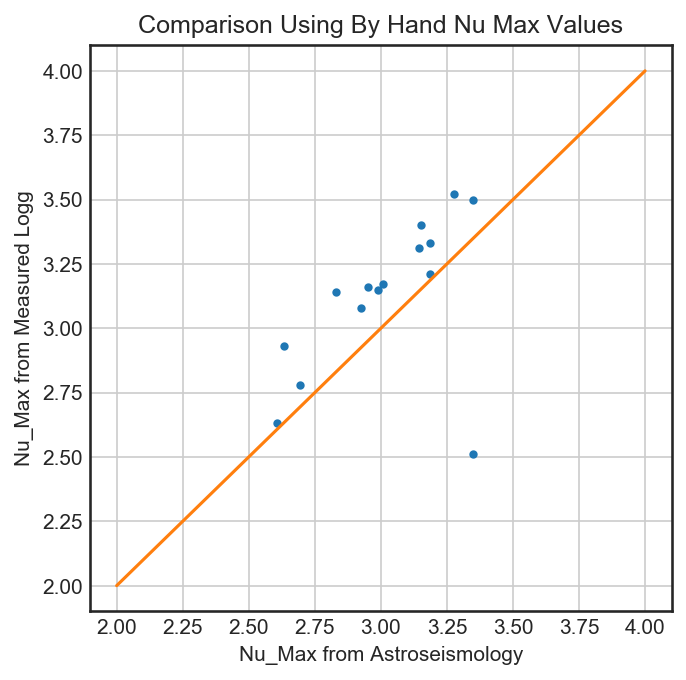

In [562]:
plt.figure(figsize=(5,5), dpi=150)
plt.title("Comparison Using By Hand Nu Max Values")
plt.plot(nu_max_to_logg(cross_matched_df['astroseismic nu_max'],cross_matched_df['meas_Teff']),cross_matched_df['meas_logg'],'.')
x=np.arange(2,5)
plt.plot(x,x)
plt.grid()
plt.ylabel("Nu_Max from Measured Logg")
plt.xlabel("Nu_Max from Astroseismology")
np.nanmedian(cross_matched_df['meas_logg']-nu_max_to_logg(cross_matched_df['astroseismic nu_max'],cross_matched_df['meas_Teff']))

0.152078629014609

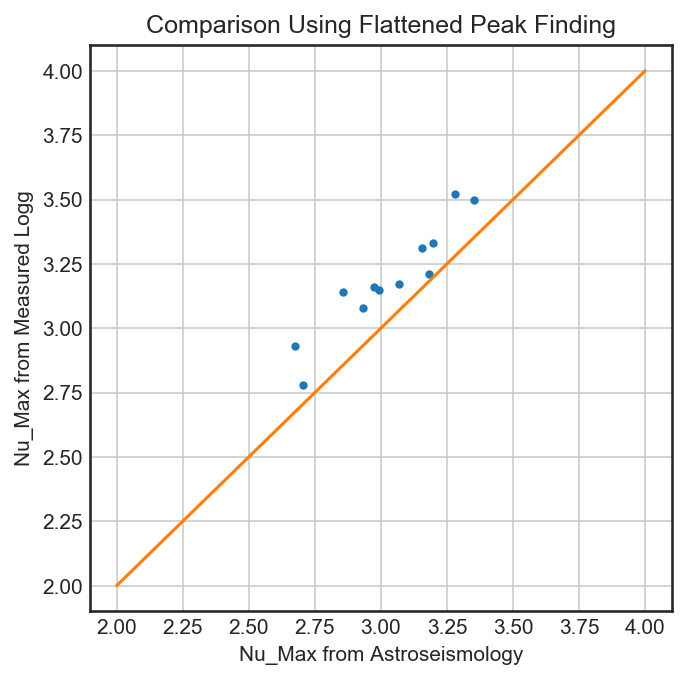

In [565]:
#Using flattened Method

matched_flattened_nu_maxes = []
for tic in cross_matched_df['TIC']:
    matched_flattened_nu_maxes.append(flatten_nu_maxes[tic])

plt.figure(figsize=(5,5), dpi=150)
plt.title("Comparison Using Flattened Peak Finding")
plt.plot(nu_max_to_logg(np.array(matched_flattened_nu_maxes),cross_matched_df['meas_Teff']),cross_matched_df['meas_logg'],'.')
x=np.arange(2,5)
plt.plot(x,x)
plt.grid()
plt.xlabel("")

plt.ylabel("Nu_Max from Measured Logg")
plt.xlabel("Nu_Max from Astroseismology")
np.nanmedian(cross_matched_df['meas_logg']-nu_max_to_logg(np.array(matched_flattened_nu_maxes),cross_matched_df['meas_Teff']))

0.15825110313755997

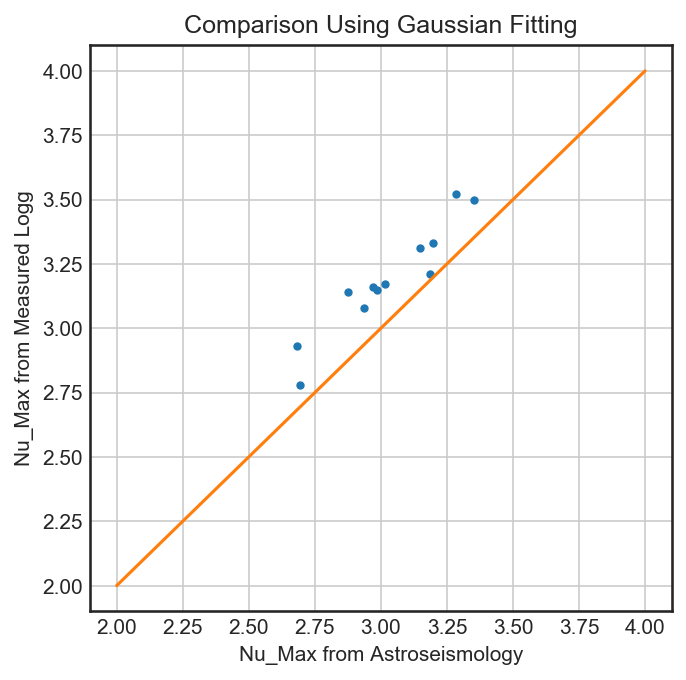

In [570]:
#Using Gaussian Fitting

matched_gauss_nu_maxes = []
for tic in cross_matched_df['TIC']:
    matched_gauss_nu_maxes.append(gauss_fitted_nu_maxes[tic])

plt.figure(figsize=(5,5), dpi=150)

plt.plot(nu_max_to_logg(np.array(matched_gauss_nu_maxes),cross_matched_df['meas_Teff']),cross_matched_df['meas_logg'],'.')
x=np.arange(2,5)
plt.plot(x,x)
plt.grid()
plt.title("Comparison Using Gaussian Fitting")
plt.ylabel("Nu_Max from Measured Logg")
plt.xlabel("Nu_Max from Astroseismology")
np.nanmedian(cross_matched_df['meas_logg']-nu_max_to_logg(np.array(matched_gauss_nu_maxes),cross_matched_df['meas_Teff']))

In [581]:
gauss_fitted_nu_maxes
nu_max_data = {'TIC':list(gauss_fitted_nu_maxes.keys()), 
               'astroseismic nu_max':list(gauss_fitted_nu_maxes.values())}

nu_max_df = pd.DataFrame.from_dict(nu_max_data)
cross_matched_df = pd.merge(tess_df, nu_max_df, on=['TIC'], how='inner')
cross_matched_df['nu_max from logg'] = [logg_to_nu_max(params[0], params[1]) for _, params in cross_matched_df[['meas_logg', 'meas_Teff']].iterrows()]

In [582]:
cross_matched_df

,TIC,TESS_sectors,TESS_cameras,TESS_ccds,meas_Teff,TESS_Teff,TESS_e_Teff,meas_logg,TESS_logg,TESS_e_logg,meas_MH,TESS_MH,TESS_e_MH,astroseismic nu_max,nu_max from logg
0,1713457,[8],[1],[3],5020.0,5027,122,3.40,--,--,0.00,--,--,NaN,308.575432
1,48237215,[6],[2],[2],4790.0,4794.52,24.1018,3.21,--,--,0.19,0.0882353,0.0257248,192.183566,203.960209
2,130867823,[10],[1],[2],4790.0,4762,122,3.03,--,--,-0.02,--,--,75.269225,134.755174
3,422432907,[10],[1],[3],4830.0,4889,30,3.20,--,--,0.01,-0.06,0.04,142.687700,198.490460
4,111947706,[11],[1],[1],4790.0,4711,50,3.21,--,--,-0.00,-0.11,0.09,133.014777,203.960209
5,72593986,[11],[1],[4],4670.0,4722,123,3.07,--,--,0.26,--,--,117.447965,149.642434
6,37763102,[3],[1],[4],4370.0,4360.7,16.96,1.91,--,--,-0.30,-0.2812,0.024,NaN,10.702186
7,71345433,[4],[2],[4],4990.0,4940,25,3.17,--,--,-0.13,-0.05,0.1,127.319345,182.248067
8,12723961,[2],[1],[4],5100.0,5003,25,3.52,--,--,-0.09,-0.05,0.1,234.811933,403.578588
9,423762307,[4],[2],[2],4970.0,4908,25,3.16,--,--,-0.12,--,0.1,115.139331,178.457584


/Users/dbranton/miniconda3/envs/astro36/lib/python3.6/site-packages/pandas/core/series.py:91: UserWarning: Warning: converting a masked element to nan.
  return converter(self.iloc[0])
/Users/dbranton/miniconda3/envs/astro36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


235.87782861550554
203.49112920652868


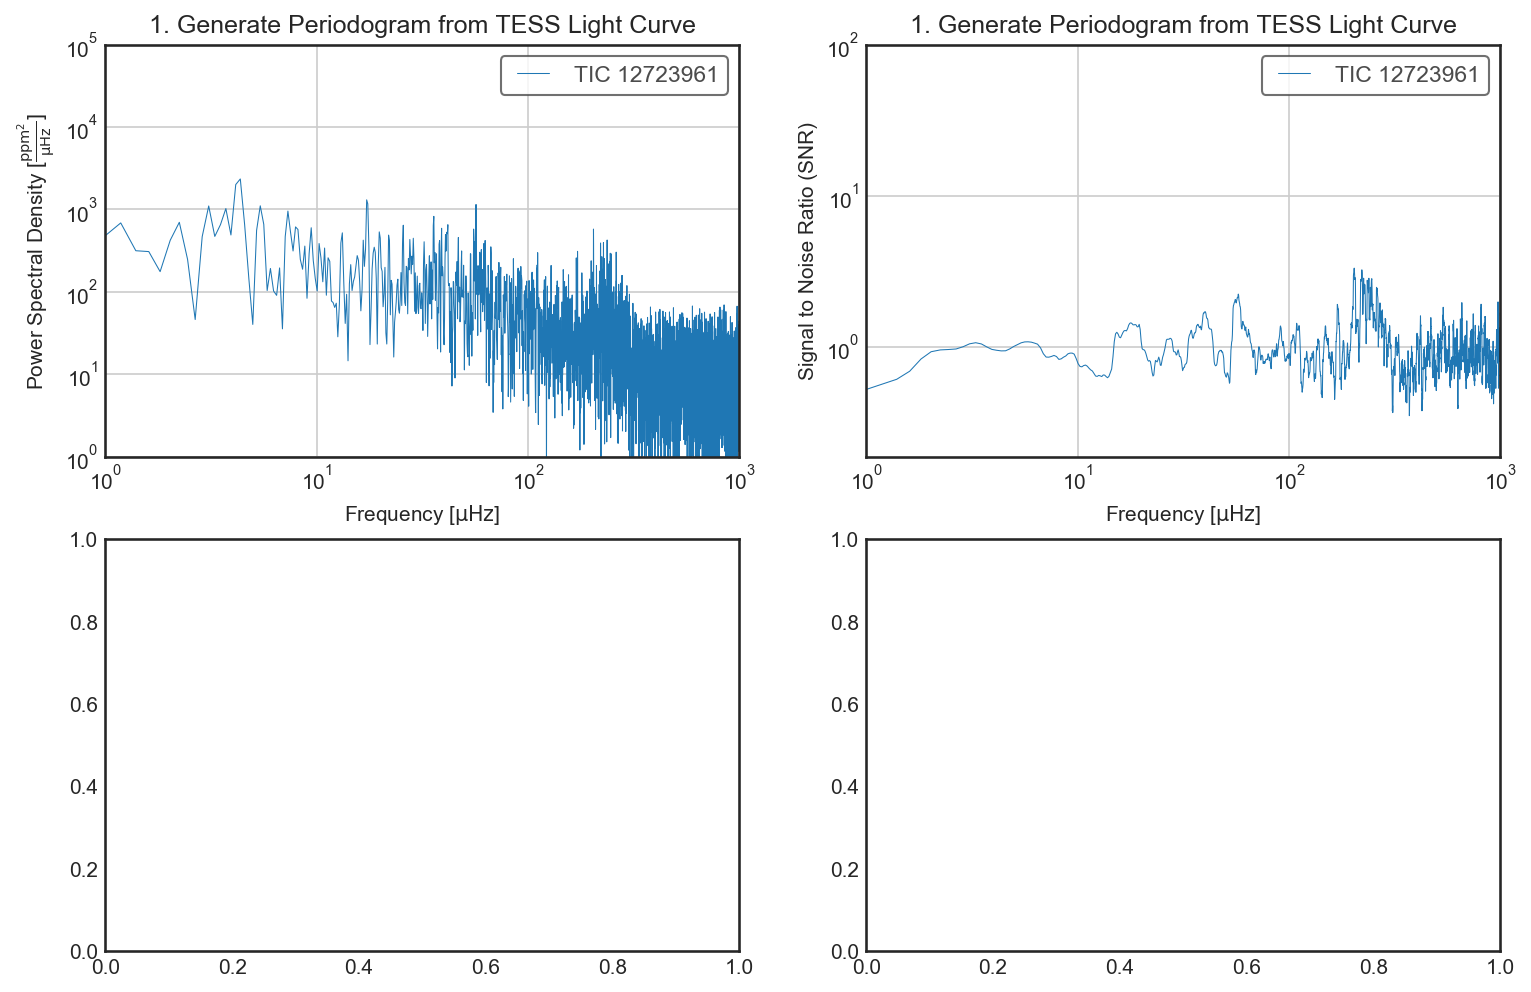

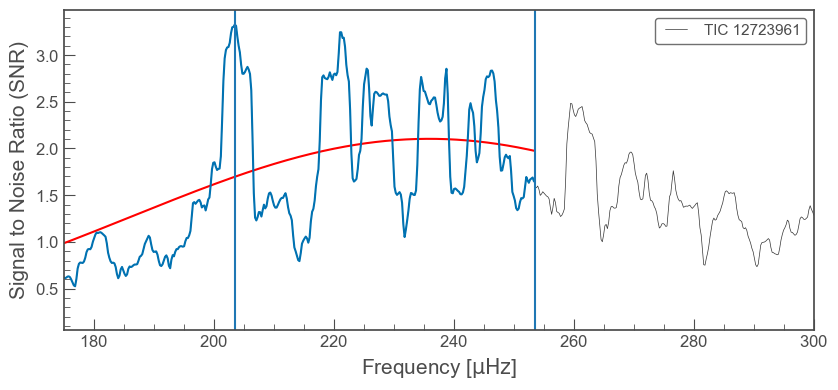

In [628]:
# Methodology plot
idx = 1
for lcf in lcfs[idx:idx+1]:
    match_df = tess_df.loc[tess_df['TIC'] == str(int(lcf.split("/")[-1].split("-")[2]))]
    nu_max_lc = logg_to_nu_max(float(match_df["meas_logg"]), float(match_df["meas_Teff"])) #measured value
    nu_max_lc_tess = logg_to_nu_max(float(match_df["TESS_logg"]), float(match_df["TESS_Teff"])) #measured value
    
    fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(12,8),dpi=150)
    lc = lightkurve.open(lcf).PDCSAP_FLUX
    #Periodogram Plot
    per3=lc.remove_nans().fill_gaps().to_periodogram(minimum_period=5*u.minute,oversample_factor=10,normalization='psd').bin(binsize=5)
    per3.plot(ax=ax1,unit=u.microHertz,scale='log')
    ax1.set_ylim(1,1e5)
    ax1.set_xlim(1,1e3)
    ax1.grid()
    ax1.set_title("1. Generate Periodogram from TESS Light Curve")
    #Flatten Plot
    per3= per3.flatten(filter_width=0.2).smooth(filter_width=5)
    per3.plot(ax=ax2,unit=u.microHertz,scale='log')
    ax2.set_ylim(-1,1e2)
    ax2.set_xlim(1,1e3)
    ax2.grid()
    ax2.set_title("2. Flatten Periodogram by converting to Signal-to-Noise")
    #plt.ylim(1,1e5)
    
    #Gaussian fit with max power frequency as guess for center

    def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))
    window=50
    nu_max_guess = per3.frequency_at_max_power.value
    mask = (np.array(per3.frequency) < nu_max_guess + window) * (np.array(per3.frequency) > nu_max_guess - window)
    masked_power = np.array(per3.power[mask])
    masked_frequency = np.array(per3.frequency.value[mask])
    
    n = len(masked_frequency)                          #the number of data
    mean = sum(masked_frequency*masked_power)/n                   #note this correction
    sigma = sum(masked_power*(masked_frequency-mean)**2)/n  
    popt,pcov = curve_fit(gaus,masked_frequency,masked_power,p0=[1,nu_max_guess,25])
    nu_max=popt[1]
    print(nu_max)
    
    
    per3.plot(unit=u.microHertz,scale='linear')
    plt.plot(masked_frequency,gaus(masked_frequency,*popt),label='fit', color='r')
    plt.plot(masked_frequency,masked_power,label='fit')
    plt.xlim(175,300)
    #plt.ylim(1,1e5)
    print(per3.frequency_at_max_power.value)
    plt.axvline(per3.frequency_at_max_power.value)
    plt.axvline(per3.frequency_at_max_power.value-window)
    plt.axvline(per3.frequency_at_max_power.value+window)
    plt.axvline(nu_max_lc, color='g')
    plt.axvline(nu_max_lc_tess, color='r')
    plt.tight_layout()
    #plt.axvline(63)
    